In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
dataset = pd.read_parquet("../data/cleaned/dataset_clean.parquet")

In [40]:
# pour sépare les variables 
 
def split_columns(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    non_numerical_columns = df.select_dtypes(exclude=['number']).columns
    return numerical_columns, non_numerical_columns

numerical_columns, non_numerical_columns = split_columns(dataset)
target = 'gravite_blessure'

# print("Numerical columns:\n", numerical_columns)
# print("\nNon-numerical columns:\n", non_numerical_columns)

C:\Users\eww\AppData\Local\Temp\ipykernel_35476\1330593993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gravite_blessure', data=dataset, palette='viridis')


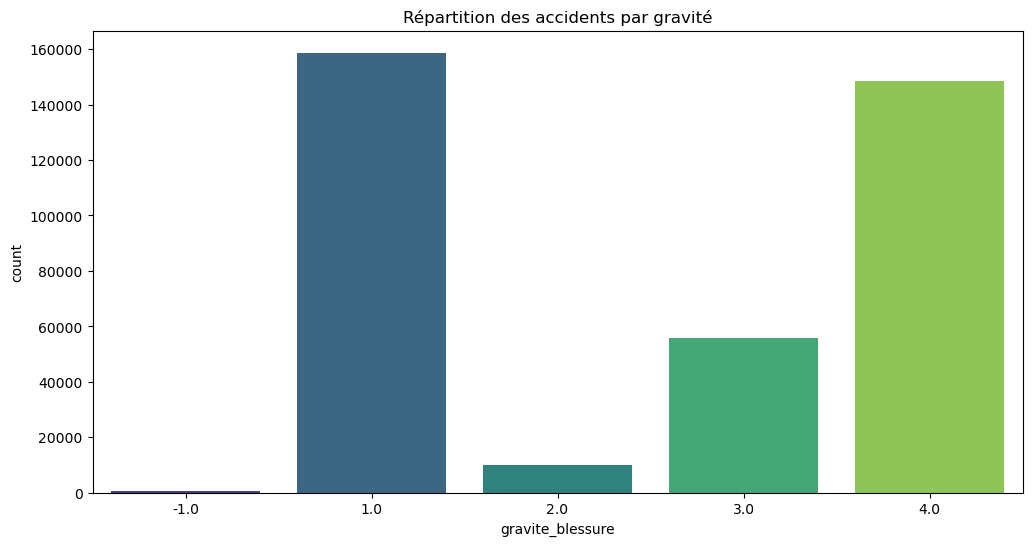

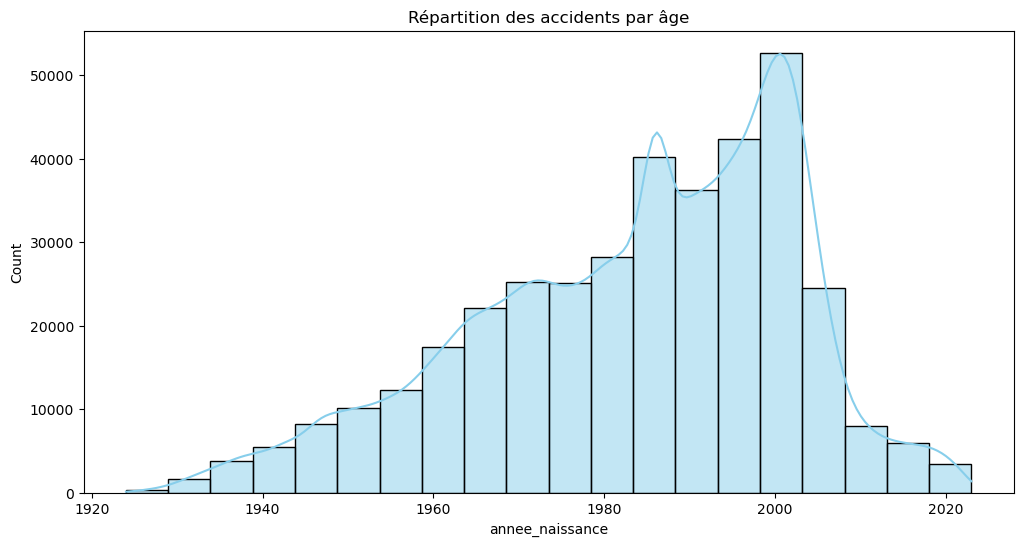

C:\Users\eww\AppData\Local\Temp\ipykernel_35476\1330593993.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='categorie_vehicule', data=dataset, palette='coolwarm')


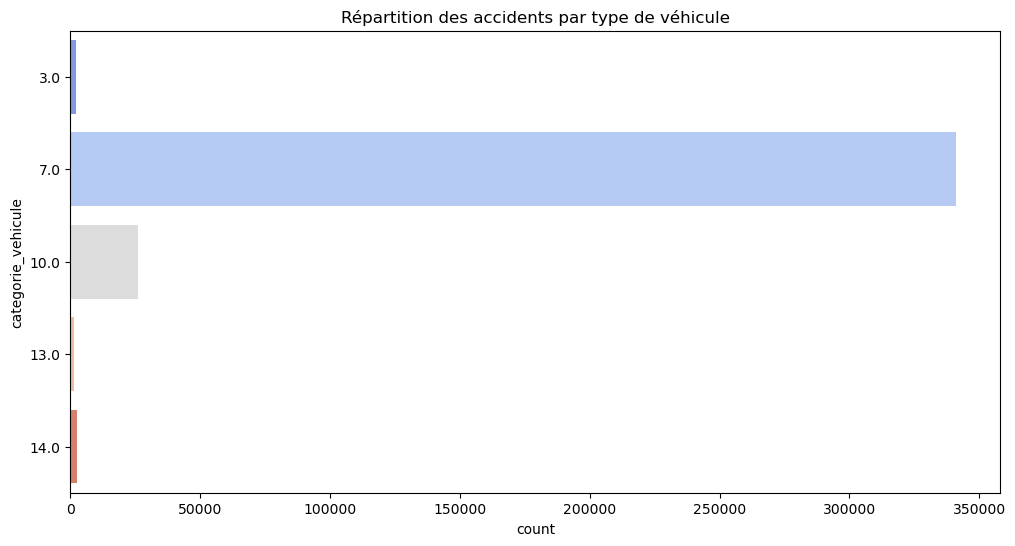

In [37]:
# Répartition par gravité
plt.figure(figsize=(12, 6)) 
sns.countplot(x='gravite_blessure', data=dataset, palette='viridis') 
plt.title("Répartition des accidents par gravité") 
plt.show() 

# Répartition par tranche d'âge
plt.figure(figsize=(12, 6)) 
sns.histplot(dataset[dataset['annee_naissance']>0]['annee_naissance'], bins=20, kde=True, color='skyblue') 
plt.title("Répartition des accidents par âge") 
plt.show() 

# Répartition par type de véhicule
plt.figure(figsize=(12, 6)) 
sns.countplot(y='categorie_vehicule', data=dataset, palette='coolwarm') 
plt.title("Répartition des accidents par type de véhicule") 
plt.show()

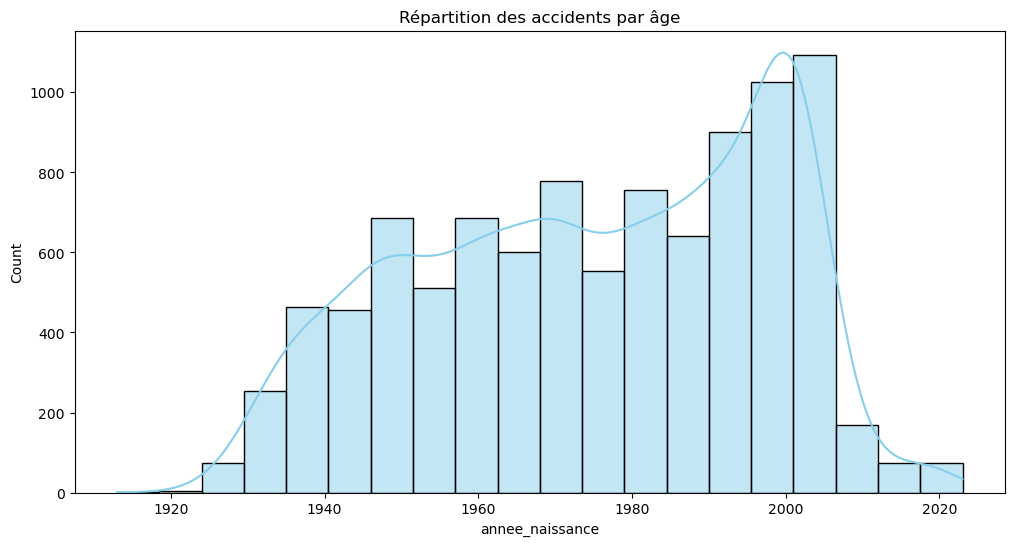

C:\Users\eww\AppData\Local\Temp\ipykernel_35476\1784837394.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='categorie_vehicule', data=dataset[dataset['gravite_blessure']==2], palette='coolwarm')


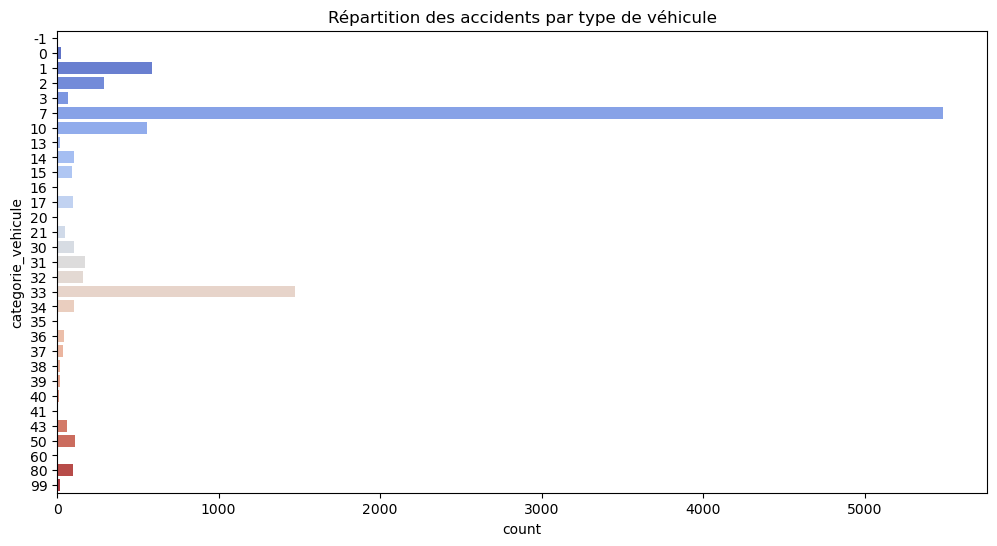

In [ ]:
#zoom sur les accidents mortels

# Répartition par tranche d'âge
plt.figure(figsize=(12, 6)) 
sns.histplot(dataset[dataset['gravite_blessure']==2]['annee_naissance'], bins=20, kde=True, color='skyblue') 
plt.title("Répartition des accidents par âge") 
plt.show() 

# Répartition par type de véhicule
plt.figure(figsize=(12, 6)) 
sns.countplot(y='categorie_vehicule', data=dataset[dataset['gravite_blessure']==2], palette='coolwarm') 
plt.title("Répartition des accidents par type de véhicule") 
plt.show()

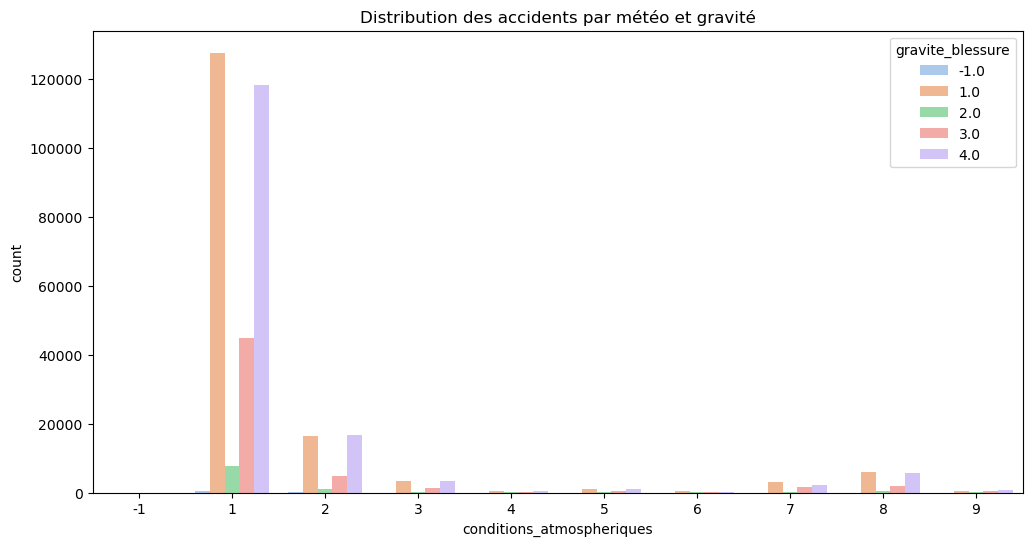

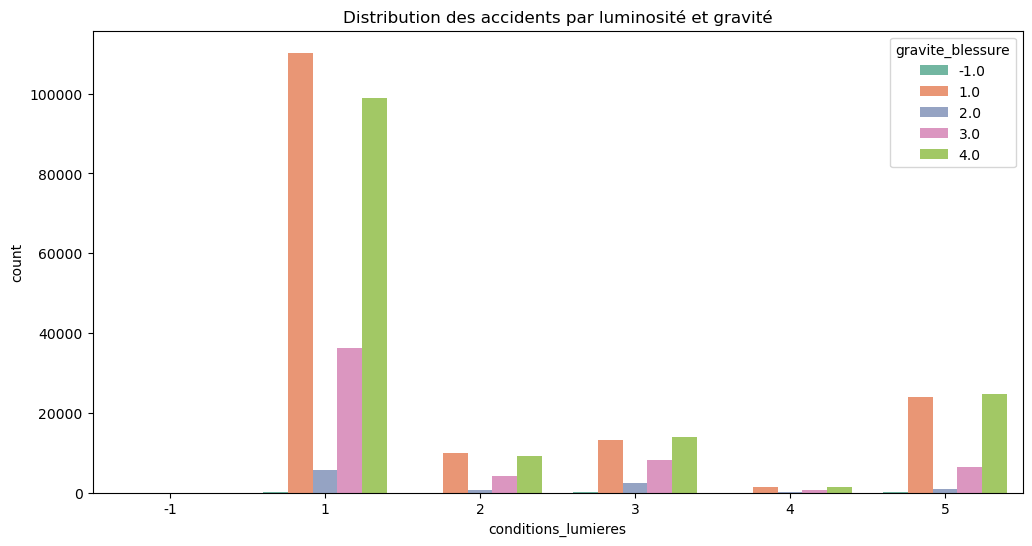

In [5]:
# Analyse par météo
plt.figure(figsize=(12, 6))
sns.countplot(x='conditions_atmospheriques', hue='gravite_blessure', data=dataset, palette='pastel')
plt.title("Distribution des accidents par météo et gravité")
plt.show()

# Analyse par luminosité
plt.figure(figsize=(12, 6))
sns.countplot(x='conditions_lumieres', hue='gravite_blessure', data=dataset, palette='Set2')
plt.title("Distribution des accidents par luminosité et gravité")
plt.show() 

In [34]:
#pourcentage de 'blessé grave' (gravite_blessure 2 ou 3) vs gravité_blessure != 2,3  grouped by conditions lumiere
data_stat = dataset[['gravite_blessure', 'conditions_lumieres', 'conditions_atmospheriques']].copy()
data_stat['gravite_blessure_2_3'] = data_stat['gravite_blessure'].apply(lambda x: 1 if x in [2,3] else 0)
data_stat['gravite_blessure_2_3'] = data_stat['gravite_blessure_2_3'].astype('category')
data_stat['conditions_lumieres'] = data_stat['conditions_lumieres'].astype('category')
data_stat['conditions_atmospheriques'] = data_stat['conditions_atmospheriques'].astype('category')

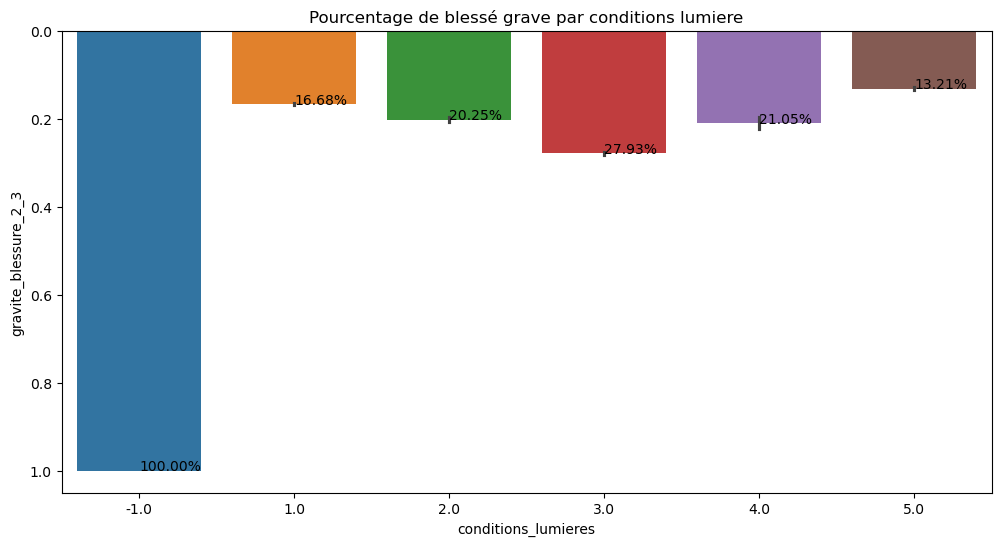

In [35]:
#zoom sur les blessés grave par rapport aux conditions lumiere
plt.figure(figsize=(12, 6))
sns.barplot(x='conditions_lumieres', y='gravite_blessure_2_3', data=data_stat, hue='conditions_lumieres', legend=False)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}', xy=(p.get_x() + p.get_width() / 2, p.get_height()))
plt.title("Pourcentage de blessé grave par conditions lumiere")
plt.show()

In [55]:
#il n'y a que des bléessés graves dans les conditions atmospheriques 'normales'
df_liste = pd.DataFrame(columns=['conditions_atmospheriques', 'count'])
for idx, i in enumerate(data_stat['conditions_atmospheriques'].unique()):
    count = dataset[((dataset['gravite_blessure'] == 2) | (dataset['gravite_blessure'] == 3)) & (dataset['conditions_atmospheriques'] == i)].shape[0]
    df_liste.loc[idx] = {'conditions_atmospheriques': i, 'count': count}
df_liste

,conditions_atmospheriques,count
0,1.0,52370


# **Data Analysis**

In [10]:
def traiter_outliers(df, var_numerique, methode='IQR', remplacement='limites'):
    """
    Traite les outliers dans les colonnes numériques d'un DataFrame.
 
    Paramètres :
    - df : pd.DataFrame - Le DataFrame contenant les données.
    - var_numerique : list - Liste des colonnes numériques à traiter.
    - methode : str - Méthode pour détecter les outliers ('IQR' ou 'zscore').
    - remplacement : str - Méthode de remplacement ('limites', 'median', 'mean').
 
    Retour :
    - df : pd.DataFrame - Le DataFrame avec les outliers traités.
    """
    for col in var_numerique:
        # Ignorer les colonnes contenant uniquement des NaN
        if df[col].isnull().all():
            continue
 
        if methode == 'IQR':
            # Calcul des limites IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            borne_inf = Q1 - 1.5 * IQR
            borne_sup = Q3 + 1.5 * IQR
        elif methode == 'zscore':
            # Calcul des Z-scores
            mean = df[col].mean()
            std = df[col].std()
            borne_inf = mean - 3 * std
            borne_sup = mean + 3 * std
        else:
            raise ValueError("Méthode non supportée. Utilisez 'IQR' ou 'zscore'.")
 
        # Remplacement des outliers en ignorant les NaN
        if remplacement == 'limites':
            df[col] = np.where(
                df[col].notna() & (df[col] < borne_inf), borne_inf, df[col]
            )
            df[col] = np.where(
                df[col].notna() & (df[col] > borne_sup), borne_sup, df[col]
            )
        elif remplacement == 'median':
            median = df[col].median()
            df[col] = np.where(
                df[col].notna() & ((df[col] < borne_inf) | (df[col] > borne_sup)),
                median,
                df[col]
            )
        elif remplacement == 'mean':
            mean = df[col].mean()
            df[col] = np.where(
                df[col].notna() & ((df[col] < borne_inf) | (df[col] > borne_sup)),
                mean,
                df[col]
            )
        else:
            raise ValueError("Remplacement non supporté. Utilisez 'limites', 'median' ou 'mean'.")
 
    return df
 
 
df_new = traiter_outliers(dataset, numerical_columns, methode='IQR', remplacement='median')
 

In [11]:
df_new[numerical_columns].describe()

,jour_accident,mois_accident,annee_accident,conditions_lumieres,localisation,type_intersection,conditions_atmospheriques,type_collision,categorie_route,regime_circulation,...,gravite_blessure,sexe_usager,annee_naissance,motif_deplacement,equipement_securite_1,equipement_securite_2,equipement_securite_3,localisation_pieton,action_pieton,etat_pieton
count,373174.000000,373174.000000,373174.000000,373174.000000,373174.000000,373174.000000,373174.0,373174.000000,373174.000000,373174.0,...,373174.000000,373174.000000,373174.000000,373174.000000,373174.000000,373174.000000,373174.0,373174.000000,373174.000000,373174.0
mean,15.594061,6.751478,2021.983782,1.899907,1.614828,1.352348,1.0,3.747113,3.326831,2.0,...,2.516381,1.310496,1983.684139,3.149954,1.099125,-0.438849,-1.0,-0.462680,-0.460380,-1.0
std,8.750320,3.331208,0.815827,1.470967,0.486636,0.670497,0.0,1.858987,0.604447,0.0,...,1.381730,0.462697,18.698370,2.776517,0.535323,0.500243,0.0,0.519752,0.508114,0.0
min,1.000000,1.000000,2021.000000,-1.000000,1.000000,1.000000,1.0,-1.000000,2.000000,2.0,...,-1.000000,1.000000,1924.000000,-1.000000,0.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0
25%,8.000000,4.000000,2021.000000,1.000000,1.000000,1.000000,1.0,2.000000,3.000000,2.0,...,1.000000,1.000000,1971.000000,0.000000,1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0
50%,16.000000,7.000000,2022.000000,1.000000,2.000000,1.000000,1.0,3.000000,3.000000,2.0,...,3.000000,1.000000,1986.000000,4.000000,1.000000,0.000000,-1.0,0.000000,0.000000,-1.0
75%,23.000000,10.000000,2023.000000,3.000000,2.000000,1.000000,1.0,6.000000,4.000000,2.0,...,4.000000,2.000000,1999.000000,5.000000,1.000000,0.000000,-1.0,0.000000,0.000000,-1.0
max,31.000000,12.000000,2023.000000,5.000000,2.000000,3.000000,1.0,7.000000,5.000000,2.0,...,4.000000,2.000000,2023.000000,9.000000,3.000000,1.000000,-1.0,1.000000,1.000000,-1.0


categorie_usager         0.217175
equipement_securite_1    0.104047
sexe_usager              0.091758
annee_naissance          0.084974
localisation_pieton      0.071196
Name: gravite_blessure, dtype: float64


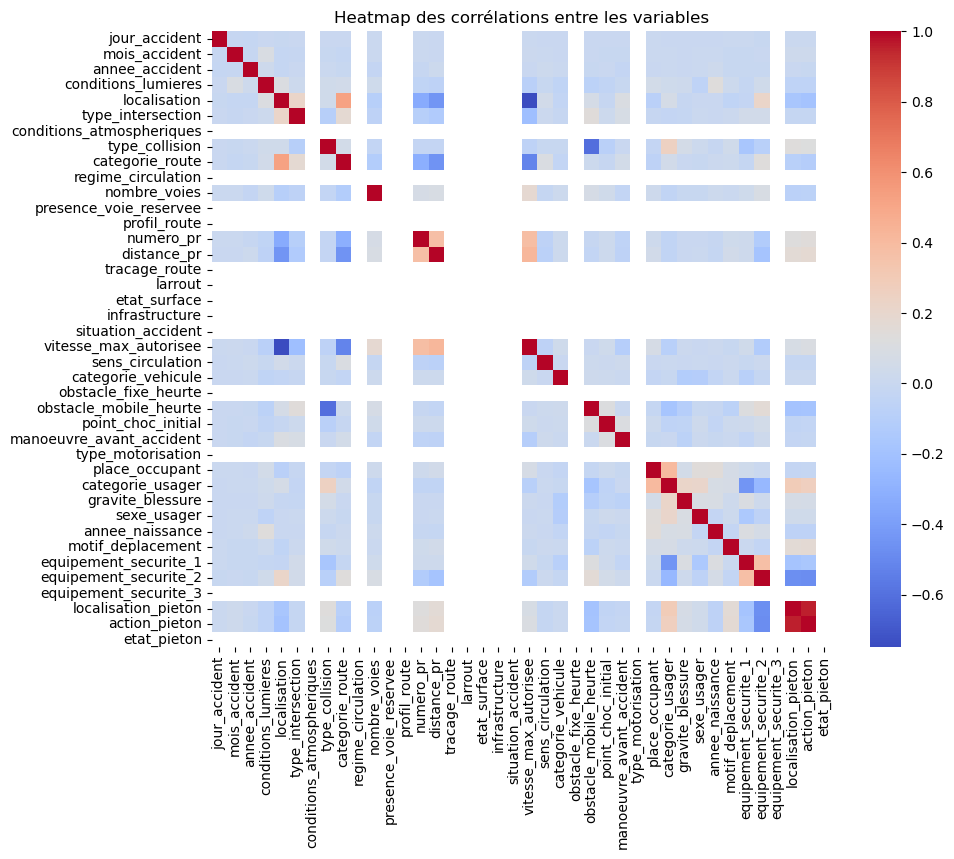

In [17]:
correlation_matrix = df_new[numerical_columns].corr()
corr_with_gravity = correlation_matrix[target].sort_values(ascending=False).drop(target)

#affiche top 5
print(corr_with_gravity[:5])

# Visualiser avec un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap des corrélations entre les variables")
plt.show()